# Фильтрация и анализ данных из подготовленной таблицы динамики признаков с использованием CNN из tf.keras
-------

**Дано:**
- имеется таблица, фиксирующая изменение всех важных признаков/фичей во времени (фичи генерировались и подбирались на предыдущем этапе);
- индексом таблицы является дата-время либо в виде TimeStamp либо в виде DateTime;
- все фичи закодированы численно либо как one-hot enc (категориальные фичи).

**Требуется:**
- разработать pipeline для эмбеддинга, кодирования окон изменения фичей с использованием AE или VAE;
- разработать функционал визуального анализа структуры кластеров кодов и соответствующих им окон;
- исследовать как архитектура сверточных слоев AE влияет на кодирование окон;
- выявить основные типы окон, которые может кодировать/распознавать/выделять АЭ в зависимости от его архитектуры.

In [1]:
# подключаем колаб к нашему гугл-диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# устанавливаем рабочую директорию/каталог
import os

path = "/content/drive/My Drive/Colab Notebooks/Moneta/"
os.chdir(path)
# print(os.listdir())

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
import seaborn as sbn
np.set_printoptions(precision=3)

import datetime as dt
print('Last Updated On: ', dt.datetime.now().date())

import sys

""" параметры графиков """
plt.style.use('ggplot')
plt.rcParams['font.fantasy'] = 'Arial', 'Times New Roman', 'Tahoma', 'Comic Sans MS', 'Courier'

Last Updated On:  2023-02-08


# ПЛАН РАБОТ
---

1. Считываем и делаем визуальный анализ попарных зависимостей данных
1. Выбираем ширину окна. Формируем датасет и даталоадер для обучения и тестирования АЭ.
1. Строим АЭ с выделением энкодера и декодера в отдельную нейросеть
1. Обучаем АЭ
1. Кодируем энкодером окна
1. Кластеризуем окна; выбираем наилучший метод и параметры силуэтным анализом (k-means, )
1. Делаем проекцию tSNE и визуализируем кластерную структуру
1. Проводим анализ получившихся кластеров окон


## **Считываем данные**
---

Подготовленные данные 

datetime|	val_00 | val_01 | ...
--- | --- | --- | ---
01.01.2009|	29,3916 | -0.108 | ...
12.01.2009|	30,5331 | 1.1415 | ...




In [4]:
prep_df = pd.read_csv('data/dollar_prepared.csv', header=0, sep=';', index_col=0) # 
print(prep_df.shape)
prep_df.tail(5)

(5052, 11)


,dollar,d_dollar,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,sin_month,cos_month
datetime,,,,,,,,,,,
2022-10-27,61.4012,-0.0743,0,0,0,1,0,0,0,-1.0,-1.836970e-16
2022-10-28,61.5294,0.1282,0,0,0,0,1,0,0,-1.0,-1.836970e-16
2022-10-29,61.5294,0.0000,0,0,0,0,0,1,0,-1.0,-1.836970e-16
2022-10-30,61.5294,0.0000,0,0,0,0,0,0,1,-1.0,-1.836970e-16
2022-10-31,61.6277,0.0983,1,0,0,0,0,0,0,-1.0,-1.836970e-16


In [5]:
import datetime as dt

prep_df.index = pd.to_datetime(prep_df.index)
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5052 entries, 2009-01-01 to 2022-10-31
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dollar         5052 non-null   float64
 1   d_dollar       5052 non-null   float64
 2   day_of_week_0  5052 non-null   int64  
 3   day_of_week_1  5052 non-null   int64  
 4   day_of_week_2  5052 non-null   int64  
 5   day_of_week_3  5052 non-null   int64  
 6   day_of_week_4  5052 non-null   int64  
 7   day_of_week_5  5052 non-null   int64  
 8   day_of_week_6  5052 non-null   int64  
 9   sin_month      5052 non-null   float64
 10  cos_month      5052 non-null   float64
dtypes: float64(4), int64(7)
memory usage: 473.6 KB


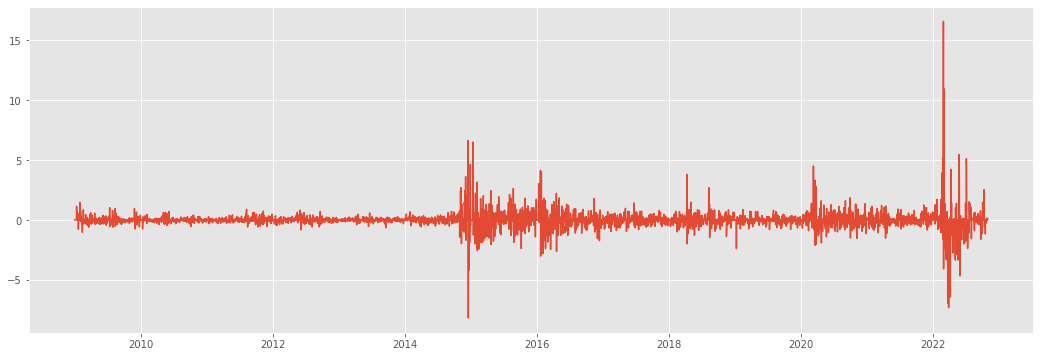

In [6]:
plt.figure(figsize=(18,6))

plt.plot(prep_df.d_dollar.index, prep_df.d_dollar.values);

## **Визуальный анализ и выбор признаков**
---
Выделим из загруженной таблицы поля, которые будем использовать для анализа

Также выделим временные границы для последующей работы: возможно, нет смысла использовать динамику курса до 2014 года - она была совсем другой. Также мы можем убрать из обучающей выборки данные 2022 года, чтобы посмотреть как будет эмбеддить сеть резкие скачки (аномалии)


In [7]:
# Устанавливаем границы выбора данных для обучающей и тестовой выборок

train_start = dt.datetime(year=2014, month=1, day=1)
train_end = dt.datetime(year=2022, month=1, day=1)
test_start = train_end
test_end = prep_df.index[-1]

train_cond = prep_df.index <= train_end
train_cond = train_cond & (prep_df.index >= train_start)
test_cond = prep_df.index >= test_start
test_cond = test_cond & (prep_df.index <= test_end)

len(prep_df), sum(train_cond), sum(test_cond)

(5052, 2923, 304)

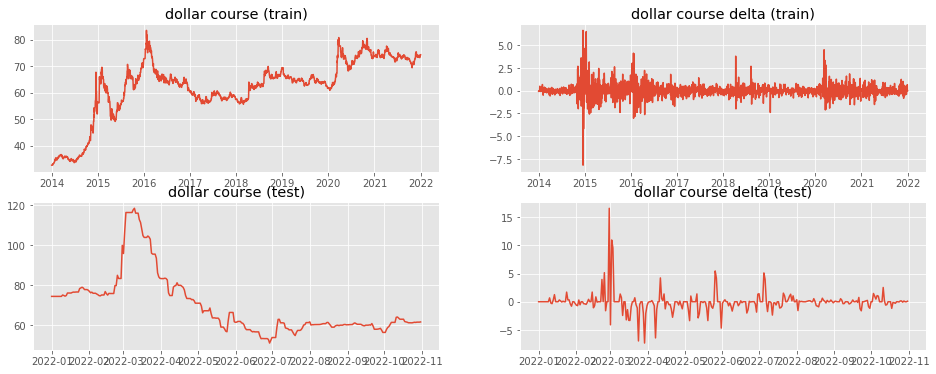

In [8]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(221)
ax1.plot(prep_df.dollar.loc[train_cond])
ax1.set_title('dollar course (train)')
ax2 = plt.subplot(222)
ax2.plot(prep_df.d_dollar.loc[train_cond])
ax2.set_title('dollar course delta (train)')

ax3 = plt.subplot(223)
ax3.plot(prep_df.dollar.loc[test_cond])
ax3.set_title('dollar course (test)')
ax4 = plt.subplot(224)
ax4.plot(prep_df.d_dollar.loc[test_cond])
ax4.set_title('dollar course delta (test)')

plt.show()

In [9]:
# посмотрим на парные зависимости между параметрами

# выберем параметры
features = ['dollar', 'd_dollar', 'day_of_week_0', 'day_of_week_5', 'day_of_week_6', 'sin_month']
# sbn.pairplot(prep_df.loc[train_cond, features]);

resume:

- необходимо шкалировать чисто числовые признаки, так как они имеют разный разброс;
- есть статистическая зависимость между сезоном (месяцем) и диапазоном и средним изменений d_dollar;
- видим, что на изменение курса доллара влияет фактор выходного дня;

### Фильтруем признаки и данные
---
- Выберем после результатов анализа зависимостей признаки, которые оказывают влияние на изменение основной величины (курса доллара); вектора с данными признаками будут подаваться на вход АЭ;

- также укажем конкретно какие признаки мы хотим эмбеддить/кодировать (остальные признаки будут вспомогательными для кодирования); эта информация будет использоваться для обучении АЭ при оценке лосса (будем требовать восстановления только данных целевых признаков);

- оформим все данные в виде отдельной таблицы df и тензора data; его далее мы и будем использовать как источника для формирования последовательностей векторов для обучения автоэнкодера;

In [10]:
# уточняем признаки, с которыми далее будем работать
prep_df.columns
features = ['dollar', 'd_dollar', 'day_of_week_5', 'day_of_week_6', 'sin_month']
# уточняем целевые признаки, которые хотим кодировать/воспроизводить
goal_features = ['dollar', 'd_dollar']
goal_indexes = [features.index(x) for x in goal_features]
print(goal_indexes)

[0, 1]


In [11]:
df = prep_df[features]
df.tail(3)

,dollar,d_dollar,day_of_week_5,day_of_week_6,sin_month
datetime,,,,,
2022-10-29,61.5294,0.0000,1,0,-1.0
2022-10-30,61.5294,0.0000,0,1,-1.0
2022-10-31,61.6277,0.0983,0,0,-1.0


### Масштабирование данных
---
- перед применение нейросети необходимо отмасштабировать данные. Это можно сделать сразу или строить pipline непосредственно при обучении/применении нейросети.

- шкалер нам может понадобиться для того, чтобы дешкалировать данные для последующего анализа.

In [12]:
df.describe()

,dollar,d_dollar,day_of_week_5,day_of_week_6,sin_month
count,5052.000000,5052.000000,5052.000000,5052.000000,5.052000e+03
mean,51.370161,0.006381,0.142914,0.142914,4.993958e-03
std,18.079718,0.650414,0.350019,0.350019,7.070891e-01
min,27.262500,-8.182200,0.000000,0.000000,-1.000000e+00
25%,31.568700,-0.094100,0.000000,0.000000,-5.000000e-01
50%,57.558500,0.000000,0.000000,0.000000,1.224647e-16
75%,65.666950,0.085050,0.000000,0.000000,8.660254e-01
max,118.438900,16.569800,1.000000,1.000000,1.000000e+00


Воспользуемся стандартным шкалером для масштабирования самого курса и его колебаний;

- нужно указать какие из признаков мы будем кодировать features_to_scale; в нашем случае набор признаков совпадает с целевыми признаками

- шкалирование производим по обучающей выборке

In [13]:
from sklearn.preprocessing import StandardScaler

dollar_scaler = StandardScaler()
features_to_scale = goal_features
dollar_scaler.fit(df.loc[train_cond, features_to_scale])

df_norm = df.copy()
df_norm.loc[:, features_to_scale] = dollar_scaler.transform(df.loc[:, features_to_scale])
df_norm.describe()

,dollar,d_dollar,day_of_week_5,day_of_week_6,sin_month
count,5052.000000,5052.000000,5052.000000,5052.000000,5.052000e+03
mean,-0.978557,-0.013103,0.142914,0.142914,4.993958e-03
std,1.624655,1.082214,0.350019,0.350019,7.070891e-01
min,-3.144887,-13.637959,0.000000,0.000000,-1.000000e+00
25%,-2.757929,-0.180292,0.000000,0.000000,-5.000000e-01
50%,-0.422468,-0.023720,0.000000,0.000000,1.224647e-16
75%,0.306162,0.117793,0.000000,0.000000,8.660254e-01
max,5.048285,27.546520,1.000000,1.000000,1.000000e+00


## **Готовим датасеты**
---
- Выбираем ширину окна win_width и шаг по окну win_step;
- формируем свой класс датасета;
- готовим datasets для обучения и для тестирования

In [14]:
import tensorflow as tf

### Класс WindowGenerator

Мы сконструируем класс WindowGenerator, в котором будет реализован метод `make_dataset` на вход которого подается a time series DataFrame и ковертируется в `tf.data.Dataset`, состоящий из пар формы `(input_window, label_window)` с использованием функции `tf.keras.utils.timeseries_dataset_from_array`.

Для генерации пар временных окон будут использоваться следующие параметры:

- input_width - это ширина входного окна;
- label_width - ширина выходного (прогнозируемого или восстанавливаемого) окна;
- shift - сдвиг индекса конца выходного окна от индекса конца входного окна;
- label_columns - если надо прогнозировать/восстанавливать только часть имеющихся в df признаков; если None, то надо все признаки восстанавливать.

Для задачи восстановления/эмбеддинга берем:

* input_width = label_width = win_width
* shift = 0

для прогнозирования вперед на predict_width:
* shift = predict_width

при этом могут быть варианты:
* label_width = shift
* label_width > shift  (для авторегрессионных моделей с частичным "teacher_forcing")

In [74]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, stride=1,
                 batch_size=1, df=df_norm, label_columns=None):
        # Store the raw data.
        self.df = df
        self.input_size = input_width
        self.batch_size = batch_size
        self.stride = stride

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=self.stride,
            shuffle=True,
            batch_size=self.batch_size)
        
        ds = ds.map(self.split_window)
        return ds

    @property
    def dataset(self):
        return self.make_dataset(self.df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.dataset))
            # And cache it for next time
            self._example = result
        return result

### Выбираем ширину окна win_width, формируем датасет последовательностей
---
данный класс можно будет использовать:
- для разделения на обучющий (до определенной даты) и тестовый (после определенной даты); 
- для оценки точности алгоритма кодирования на всей выборке;

In [75]:
# ширина окна (должна быть нечетная)
win_width = 31
win_step = 1

all_data = WindowGenerator(
    input_width= win_width,
    label_width= win_width,
    shift= 0,
    df = df_norm,
    stride= win_step,
    label_columns= goal_features
    )

all_data.dataset.element_spec

(TensorSpec(shape=(None, 31, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 31, 2), dtype=tf.float32, name=None))

In [76]:
for example_inputs, example_labels in all_data.dataset.take(2):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (1, 31, 5)
Labels shape (batch, time, features): (1, 31, 2)
Inputs shape (batch, time, features): (1, 31, 5)
Labels shape (batch, time, features): (1, 31, 2)


In [77]:
count = 0
for example_inputs, example_labels in all_data.dataset:
    count += 1

print(count)

5022


### Формируем выборки для обучения и тестирования и соответствующие датасеты
---
Применяем два этапа разбиения.
- Этап 1. Выбираем дату, разделяющую всю последовательность на две части - обучающую и тестовую; это полезно для обучения прогнозированию и выявления аномалий.

- Этап 2. Из всех последовательностей выбираем случайно определенный % для обучающей выборки; остальные - в выборку для валидизации. 

Сгенерируем датасеты для обучающей, валидизирующей и тестовой выборки

In [106]:
# шаги, с которым будем формировать данные выборки
win_step = 1
batch_size = 32

train_ds = WindowGenerator(
    input_width = win_width,
    label_width = win_width,
    shift = 0,
    df = df_norm[train_cond],
    stride = win_step,
    batch_size = batch_size,
    label_columns = goal_features
    ).dataset

test_ds = WindowGenerator(
    input_width = win_width,
    label_width = win_width,
    shift = 0,
    df = df_norm[test_cond],
    stride = win_step,
    batch_size = batch_size,
    label_columns = goal_features
    ).dataset


In [107]:
for example_inputs, example_labels in train_ds.take(2):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    # print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 31, 5)
Inputs shape (batch, time, features): (32, 31, 5)


In [108]:
batch_seq, label_seq = next(iter(train_ds))
print(batch_seq.shape, label_seq.shape)

(32, 31, 5) (32, 31, 2)


- чтобы не было проблем с загрузкой данных на девайс, лучше использовать обвертку для даталоадеров WrappedDataLoader

- При подготовке пакета для обучения/тестирования из даталоадера 
выдается тензор вида (batch_size, seq_len, features); для nn.Conv1d необходимо менять местами индексы seq_len, feature, т.е. должен на вход поступать тензор вида (batch_size, features, seq_len); мы это сделаем также в функции preprocess

In [54]:
tf.transpose(batch_seq, perm=(0, 2, 1)).shape

TensorShape([32, 5, 31])

In [22]:
"""
# это заготовка для RNN

def preprocess(x, y):
    # x, y = xy
    x = tf.transpose(x, perm=(0, 2, 1))
    y = tf.transpose(y, perm=(0, 2, 1))
    return x, y


def WrappedDataset(ds):
    prep_ds = ds.map(preprocess)
    return prep_ds

train_ds.map(preprocess).element_spec

train_ds = WrappedDataset(train_ds)

batch_seq, label_seq = next(iter(train_ds))
print(batch_seq.shape, label_seq.shape)
"""

## **Строим АЭ с выделением энкодера в отдельную нейросеть**
---
Создадим простой сверточный автоэнкодер который выделяет важные признаки в последовательностях заданной длины заданных векторов фичей.


In [248]:
# выбираем размерность скрытого слоя и размеры ядер свертки
latent_dim = 49
kernels = (5, 5)
n_features = len(features)
n_labels = len(goal_features)
dropout = 0.2

### Энкодер (Кодировщик последовательностей)
---

In [249]:
encoder = tf.keras.Sequential([
    tf.keras.layers.Conv1D(latent_dim*2, kernel_size=1, strides=1, padding='same', activation='elu'), 
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Conv1D(latent_dim*4, kernel_size=kernels[0], strides=2, padding='same', activation='elu' ), 
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Conv1D(latent_dim*8, kernel_size=kernels[1], strides=2, padding='same', activation='elu'), 
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Conv1D(latent_dim*16, kernel_size=(win_width+1)//4, strides=1, activation='elu'), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(latent_dim)
])

batch_seq, _ = next(iter(train_ds))
print(batch_seq.shape, encoder(batch_seq).shape)
encoder.summary()

(32, 31, 5) (32, 49)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (32, 31, 98)              588       
                                                                 
 dropout_66 (Dropout)        (32, 31, 98)              0         
                                                                 
 conv1d_37 (Conv1D)          (32, 16, 196)             96236     
                                                                 
 dropout_67 (Dropout)        (32, 16, 196)             0         
                                                                 
 conv1d_38 (Conv1D)          (32, 8, 392)              384552    
                                                                 
 dropout_68 (Dropout)        (32, 8, 392)              0         
                                                                 
 conv1d_39 (Conv1D)          (32

In [250]:
code = encoder(batch_seq)
batch_seq.shape, code.shape

(TensorShape([32, 31, 5]), TensorShape([32, 49]))

### Декодер (Генератор последовательностей)
---

In [251]:
# Для Conv1DTranspose можно использовать следующую формулу расчета длины последовательности
# new_timesteps = ((timesteps - 1) * strides + kernel_size - 2 * padding + output_padding)

decoder = tf.keras.Sequential([
    tf.keras.layers.Reshape((1, latent_dim), input_shape=(latent_dim,)),
    tf.keras.layers.Conv1DTranspose(n_features * 16, kernel_size=3, strides=1, activation='elu'), 
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Conv1DTranspose(n_features * 8, kernel_size=kernels[0], strides=2, activation='elu' ), 
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Conv1DTranspose(n_features * 4, kernel_size=kernels[1], strides=2, activation='elu'), 
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Conv1D(n_labels * win_width, kernel_size=(4+kernels[0] - 1)*2 + kernels[1], strides=1), 
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(dropout),
    #tf.keras.layers.Dense(n_labels * win_width),
    tf.keras.layers.Reshape((win_width, n_labels))
    # tf.keras.layers.Permute((2, 1)), 
])

print(code.shape, decoder(code).shape)
decoder.summary()

(32, 49) (32, 31, 2)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_20 (Reshape)        (None, 1, 49)             0         
                                                                 
 conv1d_transpose_44 (Conv1D  (None, 3, 80)            11840     
 Transpose)                                                      
                                                                 
 dropout_69 (Dropout)        (None, 3, 80)             0         
                                                                 
 conv1d_transpose_45 (Conv1D  (None, 9, 40)            16040     
 Transpose)                                                      
                                                                 
 dropout_70 (Dropout)        (None, 9, 40)             0         
                                                                 
 conv1d_transpose_46 (Conv1D  (N

In [252]:
decode = decoder(code)
code.shape, decode.shape

(TensorShape([32, 49]), TensorShape([32, 31, 2]))

### Автоэнкодер
---

In [253]:
def CNN_ae(encoder, decoder):
    input_seq = tf.keras.layers.Input(shape=(win_width, n_features))
    code = encoder(input_seq)
    output_seq = decoder(code)
    autoencoder = tf.keras.Model(input_seq, output_seq, name="autoencoder")
    return autoencoder

cnn_ae = CNN_ae(encoder, decoder)

cnn_ae.compile(optimizer='adam', loss='mean_squared_error', metrics= [tf.keras.metrics.MeanAbsoluteError()])

cnn_ae.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 31, 5)]           0         
                                                                 
 sequential_20 (Sequential)  (None, 49)                2982385   
                                                                 
 sequential_21 (Sequential)  (None, 31, 2)             58002     
                                                                 
Total params: 3,040,387
Trainable params: 3,038,819
Non-trainable params: 1,568
_________________________________________________________________


In [254]:
reconstucted_seq = cnn_ae(batch_seq)
reconstucted_seq.shape, batch_seq.shape

(TensorShape([32, 31, 2]), TensorShape([32, 31, 5]))

## **Обучаем АЭ**
---

In [255]:
history_c = None

In [256]:
from IPython.core import history
epochs = 10

history_1 = cnn_ae.fit(train_ds, epochs=epochs,  shuffle=True, validation_data=test_ds, verbose=1)

Epoch 1/10
91/91 [==============================] - 28s 293ms/step - loss: 0.4688 - mean_absolute_error: 0.4089 - val_loss: 3.5003 - val_mean_absolute_error: 0.8320
Epoch 2/10
91/91 [==============================] - 25s 274ms/step - loss: 0.2871 - mean_absolute_error: 0.3407 - val_loss: 1.9138 - val_mean_absolute_error: 0.7056
Epoch 3/10
91/91 [==============================] - 25s 270ms/step - loss: 0.2339 - mean_absolute_error: 0.3153 - val_loss: 1.3071 - val_mean_absolute_error: 0.5815
Epoch 4/10
91/91 [==============================] - 26s 283ms/step - loss: 0.2101 - mean_absolute_error: 0.3038 - val_loss: 1.2330 - val_mean_absolute_error: 0.6297
Epoch 5/10
91/91 [==============================] - 25s 276ms/step - loss: 0.1930 - mean_absolute_error: 0.2891 - val_loss: 1.0099 - val_mean_absolute_error: 0.5072
Epoch 6/10
91/91 [==============================] - 25s 276ms/step - loss: 0.1784 - mean_absolute_error: 0.2812 - val_loss: 1.0558 - val_mean_absolute_error: 0.5038
Epoch 7/10

In [257]:
if history_c:
    for key, vals in history_1.history.items():
        history_c.history[key] += vals
else:
    history_c = history_1

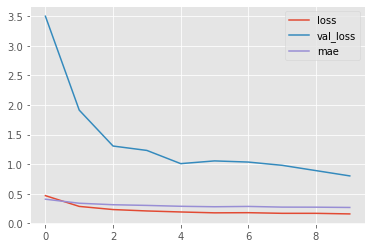

In [258]:
plt.plot(history_c.history['loss'], label='loss')
plt.plot(history_c.history['val_loss'], label='val_loss')
plt.plot(history_c.history['mean_absolute_error'], label='mae')
plt.legend(loc= 'upper right');

## Посмотрим на восстановленные данные и сравним с исходными
---
для того, чтобы восстановить и посмотреть на всю последовательность, мы агрегируем оконные восстановленные последовательности. Т.е. усредним показатели на данный момент времени, полученные из разных окон после применения автоэнкодера.

In [259]:
# сформируем весь датасет в виде torch.Tensor
all_x = []

for x1, y1 in all_data.dataset:
    all_x.append(x1)

all_data_batch = tf.concat(all_x, axis=0)
rec_data_batch = cnn_ae(all_data_batch)

all_data_batch.shape, rec_data_batch.shape

(TensorShape([5022, 31, 5]), TensorShape([5022, 31, 2]))

In [82]:
def aggregate_predictions(y_hat_batch):
    """
    Aggregates predictions for each timestep. When predicting n steps
    ahead where n > 1, these are multiple predictions for a timestep.
    Args:
        y_hat_batch (np.arr): predictions shape (<batch length>, <n_preds)
    """
    # initialization
    n_times = y_hat_batch.shape[0]
    n_preds = y_hat_batch.shape[1]
    agg_y_hat = np.zeros(shape=(n_times + n_preds - 1,))
    temp_y_hat = np.zeros(shape=(n_times + n_preds - 1, n_preds))
    # сдвинем i-й столбец y_hat_batch на i позиций вниз в temp_y_hat
    # так чтобы в j-й строке были все прогнозы для j-го момента времени
    for col in range(y_hat_batch.shape[1]):
        temp_y_hat[col: col + n_times, col] = y_hat_batch[:, col]

    # вычислим среднее по каждому моменту времени
    agg_y_hat = np.mean(temp_y_hat, axis=1)

    # поправим хвосты
    for row in range(n_preds-1):
        agg_y_hat[row] = np.mean(temp_y_hat[row, 0:row+1])
        agg_y_hat[-row-1] = np.mean(temp_y_hat[-row-1, -row-1:])

    return agg_y_hat, temp_y_hat

Объединим реконструированный сигнал усреднением по всем окнам

In [260]:
rec_data_list = []
for i, index in enumerate(goal_indexes):
    np_reconstr_data_batch = rec_data_batch[:, :, i].numpy()
    agg_reconstr_data, temp_reconstr_data = aggregate_predictions(np_reconstr_data_batch)
    rec_data_list.append(agg_reconstr_data.reshape(-1, 1))

# их надо демасштабировать
rec_goal_data = np.concatenate(rec_data_list, axis=1)
rec_descale_data = dollar_scaler.inverse_transform(rec_goal_data)

np_reconstr_data_batch.shape, agg_reconstr_data.shape, rec_descale_data.shape

((5022, 31), (5052,), (5052, 2))

посмотрим на восстановленные данные

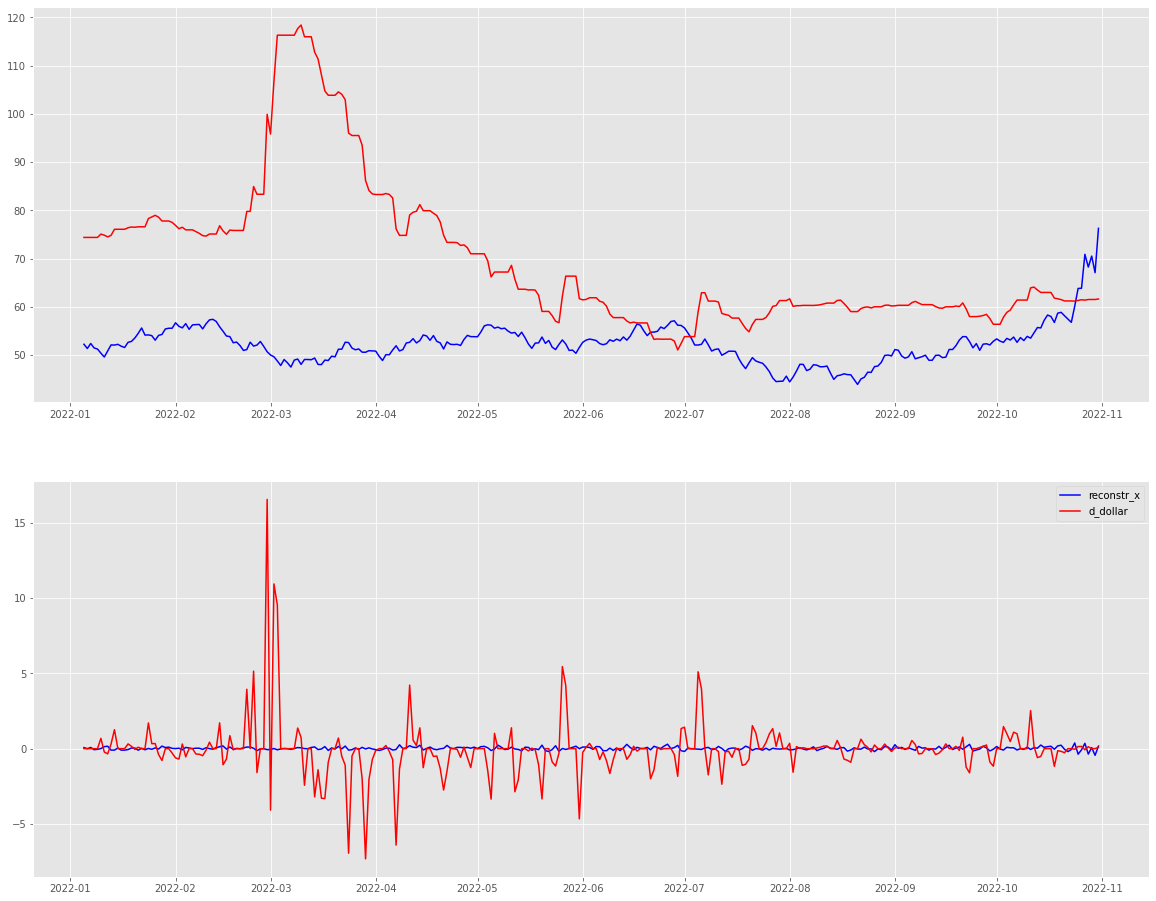

In [261]:
#plt.figure(figsize=(16, 16))
n_points=300  # кол-во анализируемых последних точек (в тестовом диапазоне)

fig, ax = plt.subplots(len(goal_indexes), 1, figsize=(20, 16))

for i, index in enumerate(goal_indexes):
    ax[index].plot(df.index[-n_points:], rec_descale_data[-n_points:, i], c='blue', label='reconstr_x')
    ax[index].plot(df.index[-n_points:], df.iloc[-n_points:, index], c='red', label=goal_features[i])
plt.legend()
plt.show()

## **Кластеризуем окна (k-means, agglomerative, ward, DBSCAN, ...)**
---

**Кодируем энкодером последовательности**

In [87]:
codes = []

for x1, y1 in all_data.dataset:
    code = encoder(x1)
    codes.append(code.numpy().reshape(1, -1))

all_codes = np.concatenate(codes, axis=0)
all_codes.shape

(5022, 32)

## **Делаем проекцию tSNE и визуализируем структуру кодов**
---

In [88]:
from sklearn.manifold import TSNE

X = all_codes
tsne = TSNE(n_components=2, perplexity=45)
X_tsne = tsne.fit_transform(X)
X_tsne.shape

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(5022, 2)

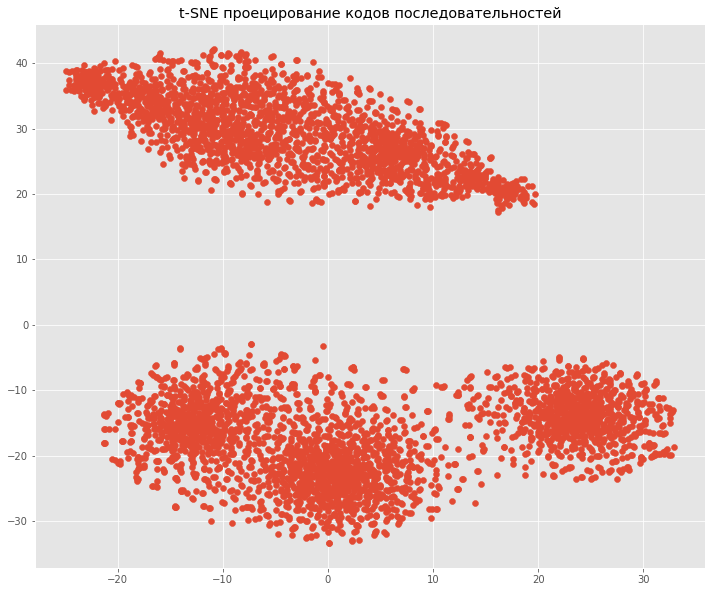

In [89]:
plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('t-SNE проецирование кодов последовательностей');

## Выполним кластеризацию и проанализируем получившуюся структуру кластеров
---

### Метод kmeans++.
---
Определим оптимальное кол-во кластеров

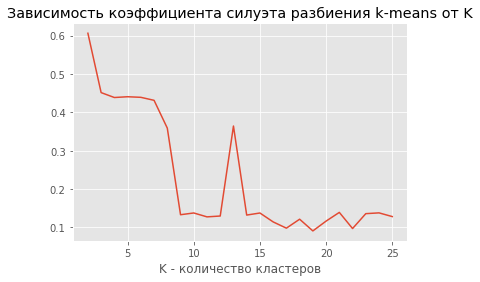

In [90]:
# Применение k-means
from sklearn.cluster import KMeans
from sklearn import metrics

X = all_codes
k_start = 2
k_end = 25

crit2 = []
for k in range(k_start, k_end + 1):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X)
    crit2.append(metrics.silhouette_score(X, kmeans.labels_))

plt.plot(range(k_start, k_end + 1), crit2)
plt.xlabel('K - количество кластеров')
plt.title('Зависимость коэффициента силуэта разбиения k-means от K');

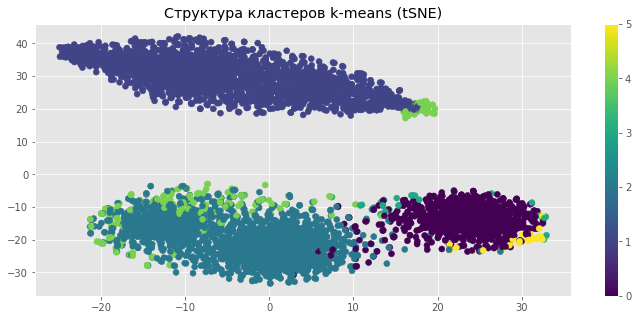

In [93]:
kmeans = KMeans(n_clusters=6, init='k-means++', n_init=15, random_state=123)

# применяем - обучаем
kmeans.fit(X)
# метки кластеров
labels = kmeans.labels_
# визуализируем получившееся разбиение с учетом знания цифр на картинках
# и сравним с разбиением на кластеры, полученным с помощью k-means
plt.figure(figsize=(12,5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels)
plt.colorbar()
plt.title('Структура кластеров k-means (tSNE)')
plt.show()

In [94]:
pd.Series(labels).value_counts()

1    2094
2    1798
0     857
4     219
5      30
3      24
dtype: int64

Проанализируем примеры последовательностей из разных кластеров

In [97]:
centers_code = tf.Variable(kmeans.cluster_centers_, dtype=tf.float32)
centers_code = tf.reshape(centers_code, (*centers_code.shape, 1))
centers_seq = decoder(centers_code)
np_centers_seq = centers_seq.numpy()
centers_code.shape, centers_seq.shape, np_centers_seq.shape

(TensorShape([6, 32, 1]), TensorShape([6, 31, 2]), (6, 31, 2))

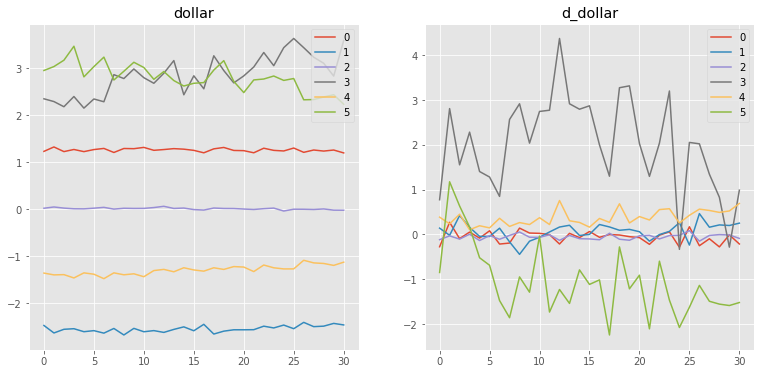

In [99]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

# визуализируем получившиеся последовательности
for index in goal_indexes:
    ax[index].set_title(df.columns[index])
    for label in np.unique(labels):
        ax[index].plot(range(win_width), np_centers_seq[label, :, index].ravel(), label=str(label))
        ax[index].legend()

fig.show()

### Метод DBSCAN
---

Этот метод интересен тем, что он может помочь выявить аномалии

In [ ]:
from sklearn.cluster import DBSCAN

X = all_codes

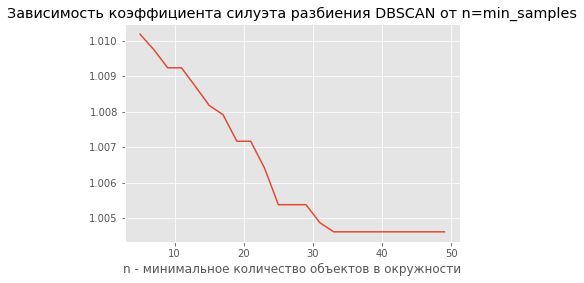

In [ ]:
# применим силуэтный анализ
n_start = 5
n_end = 50
n_step = 2

crit3 = []
for n in range(n_start, n_end + 1, n_step):
    dbscan = DBSCAN(eps=5.0, min_samples=n, metric='euclidean',  algorithm='auto')
    dbscan.fit(X)
    X1 = X[dbscan.labels_ != -1]
    labels_1 = dbscan.labels_[dbscan.labels_ != -1]
    crit3.append(metrics.silhouette_score(X1, labels_1) * len(np.unique(labels_1)) * len(X1) / len(X))

plt.plot(range(n_start, n_end + 1, n_step), crit3)
plt.xlabel('n - минимальное количество объектов в окружности')
plt.title('Зависимость коэффициента силуэта разбиения DBSCAN от n=min_samples');

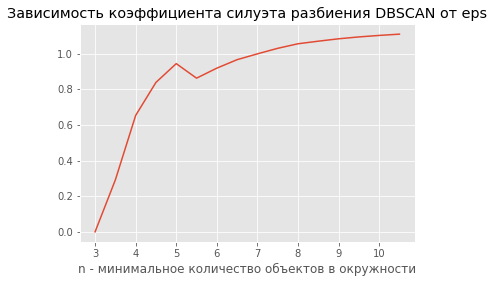

In [ ]:
# применим силуэтный анализ
eps_start = 3
eps_end = 10
eps_step = 0.5

crit3 = []
for eps in np.arange(eps_start, eps_end + 1, eps_step):
    dbscan = DBSCAN(eps=eps, min_samples=10, metric='euclidean',  algorithm='auto')
    dbscan.fit(X)
    X1 = X[dbscan.labels_ != -1]
    labels_1 = dbscan.labels_[dbscan.labels_ != -1]
    crit3.append(metrics.silhouette_score(X1, labels_1) * len(np.unique(labels_1)) * len(X1) / len(X))

plt.plot(np.arange(eps_start, eps_end + 1, eps_step), crit3)
plt.xlabel('n - минимальное количество объектов в окружности')
plt.title('Зависимость коэффициента силуэта разбиения DBSCAN от eps');

выберем значения параметров

In [ ]:
dbscan = DBSCAN(eps=4.0, min_samples=35, metric='euclidean',  algorithm='auto')
dbscan.fit(X)
labels_1 = dbscan.labels_
pd.Series(labels_1).value_counts()

-1    2346
 0    1747
 1     764
 2     165
dtype: int64

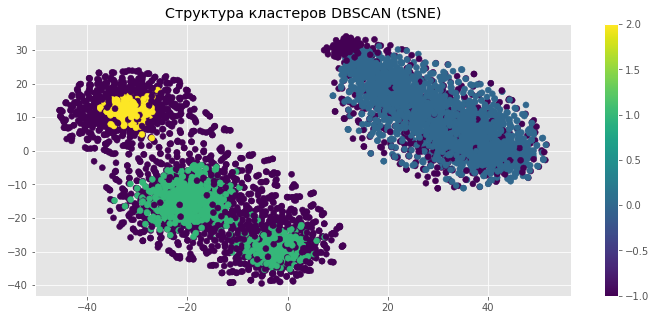

In [ ]:
# визуализируем получившееся разбиение с учетом знания цифр на картинках
# и сравним с разбиением на кластеры, полученным с помощью k-means
plt.figure(figsize=(12,5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_1)
plt.colorbar()
plt.title('Структура кластеров DBSCAN (tSNE)')
plt.show()

проанализируем примеры последовательностей из разных кластеров

In [ ]:
labels_1 = dbscan.labels_[dbscan.labels_ != -1]
cluster_centers = np.array([X[dbscan.labels_ == label].mean(axis=0) for label in range(max(dbscan.labels_)+1)])
cluster_centers.shape

(3, 20)

In [ ]:
centers_code = tf.Variable(cluster_centers, dtype=tf.float32)
centers_code = tf.reshape(centers_code, (*centers_code.shape, 1))
centers_seq = decoder(centers_code)
np_centers_seq = centers_seq.numpy()
centers_code.shape, centers_seq.shape, np_centers_seq.shape

<ipython-input-572-f2485d35cc10>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  centers_code = torch.tensor(torch.from_numpy(cluster_centers), dtype=torch.float32, device=device)


(torch.Size([3, 20]), torch.Size([3, 5, 31]), (3, 5, 31))

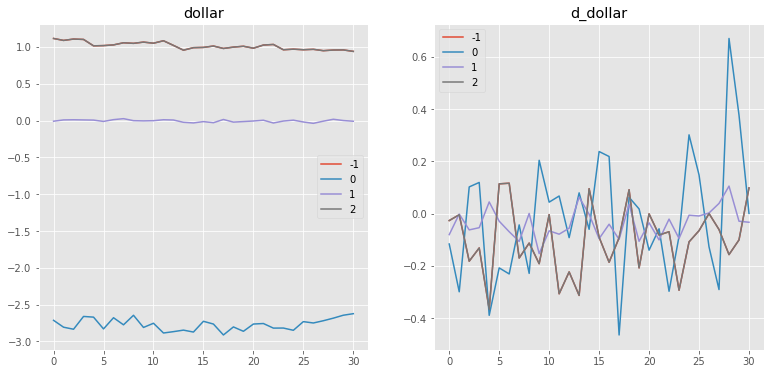

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

# визуализируем получившиеся последовательности
for index in goal_indexes:
    ax[index].set_title(df.columns[index])
    for label in np.unique(labels):
        ax[index].plot(range(win_width), np_centers_seq[label, :, index].ravel(), label=str(label))
        ax[index].legend()

fig.show()

### Иерархическая кластеризация
---

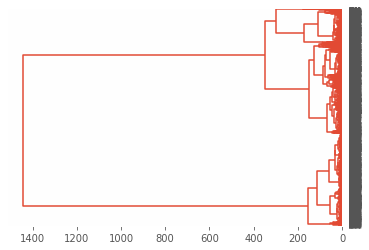

In [100]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

X = all_codes

Z = linkage(X, method='ward', metric='euclidean')

dend = dendrogram(Z, orientation='left', color_threshold=0.0)

In [103]:
labels_2 = fcluster(Z, 150, criterion='distance')
pd.Series(labels_2).value_counts()

2    2061
3    1073
4    1016
6     739
1      78
5      25
8      18
7      12
dtype: int64

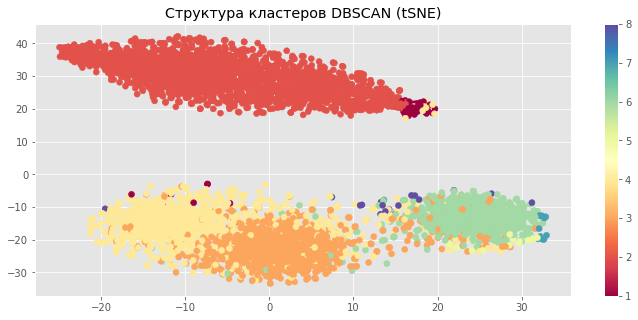

In [104]:
# визуализируем получившееся разбиение с учетом знания цифр на картинках
# и сравним с разбиением на кластеры, полученным с помощью k-means
plt.figure(figsize=(12,5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_2, cmap=plt.cm.Spectral)
plt.colorbar()
plt.title('Структура кластеров DBSCAN (tSNE)')
plt.show()

## **Сохранение обученной модели**
------

In [105]:
model_name = 'cnn_ae-seq' + str(win_width) + '-ls' + str(latent_dim) + '_k' + '-'.join([str(k) for k in kernels]) + '-2'
print(model_name)
cnn_ae.save(path + 'models/' + model_name)

cnn_ae-seq31-ls32_k5-3-2
